

# Details of machine learning and optimization
**Hands on: Optimising production of a hydro power plant**

This is a Jupyter notebook. You can run the code in each cell with "shift + enter" (or the run button above). Think of it as a script with blocks that can be run independently.

The intention with this notebook is for you to get familiar with some more advanced details of machine learning and an example of how to combine it with optimization. Focus on the concepts rather than the code. 

## Running locally
In order to run the notebook on your local machine, you need python 3.7 and the packages described in the environment.yml file.

## Running on Colab
The notebook can be run on Google Colab. The first cells below show how to get access to datafiles and all the required packages that we have installed in a sharable folder.



**The notebook is running on a remote server. This means that you wont have to setup anything. When you are finished, you can save it to your own laptop under "File" and "Download as". However, in order to run locally you will also need the datafiles, python 3.6 or 3.7 and all the necessary packages (easily installed with anaconda).



The instructions for the exercises are given in orange text.**




In [ ]:
# Accessing data files. This requires that the folder has been shared on Google 
# Drive and will prompt for authorization
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/DigitalAcademyDatafiles/'
# Link environment file to running directory
!ln -s '/content/drive/MyDrive/DigitalAcademyDatafiles/environment.yml' .

Mounted at /content/drive


In [ ]:
# Alternatively files can be uploaded manually
# Required files are environment.yml, 2res6turbines.png and 
# plant_with_6_gen_tailrace_loss.h5, aux_functions.py
#from google.colab import files
#uploaded = files.upload()
# Chose file

In [ ]:
filepath = '/content/drive/MyDrive/DigitalAcademyDatafiles/'

In [ ]:

# Installing condacolab. Unfortunately, this has to be done every time you restart the notebook. Takes approx a minute.
!pip install --target=$nb_path condacolab
import condacolab

  Using cached condacolab-0.1.3-py3-none-any.whl (6.8 kB)


In [ ]:
condacolab.install()
!conda env update -n base -f environment.yml

In [ ]:
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...


KeyboardInterrupt: ignored

In [ ]:
import condacolab
#condacolab.check()

In [1]:
# We will use IPopt later for optimization
import cyipopt

# Details of machine learning and optimization
**Hands on: Optimising production of a hydro power plant**

## Instructions

PLEASE READ ALL INSTRUCTIONS EVEN IF YOU THINK THEY LOOK FAMILIAR FROM "INTRODUCTION TO MACHINE LEARNING". THEY ARE NOT THE SAME...

This is a jupyter notebook. You can run the code in each cell with "shift + enter" (or the run button above). Think of it as a script with blocks that can be run independently.

The notebook is running on a remote server. This means that you wont have to setup anything. When you are finished, you can save it to your own laptop under "File" and "Download as". However, in order to run locally you will also need the datafiles, python 3.6 or 3.7 and all the necessary packages (easily installed with anaconda).

The intention with this notebook is for you to get familiar with some more advanced details of machine learning and an example of how to combine it with optimization. Focus on the concepts rather than the code. 

The instructions for the exercises are given in orange text.

## Load the relevant python packages

INCLUDE NECESSARY FUNCTIONS FROM AUX HERE INSTEAD OF IMPORTING...

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# numpy allows for efficient array operations
import numpy as np

# pandas is used to structure all data in data frames and do simple operations. Works well for datasets that are 
# sufficiently small they can be stored in memory.
import pandas as pd 

# scikit-learn contains simple and efficient tools for data mining and data analysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Feature scaling
from sklearn.model_selection import train_test_split  # Splitting test and training data randomly
from sklearn.model_selection import cross_val_score  # Model evaluation
from sklearn.model_selection import RandomizedSearchCV  # Hyper parameter search
from sklearn.metrics import mean_squared_error  # Metric
from scipy.stats import randint, uniform

# keras is a high-level interface for deep learning. We will use tensorflow as backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Functions for this specific dataset. Feel free to have a look in the file aux_functions.py
from aux_functions import *

# We use Matplotlib pyplot for visualisation
import matplotlib.pyplot as plt
from IPython.display import Image

# seaborn provide useful statistical tools and quick visualisation
import seaborn as sns  

# We will use IPopt later for optimization
import cyipopt

# To see time impact
import time

plt.style.use('ggplot')

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.autograph.set_verbosity(0)

## The modelling challenge
Consider a hydro power plant with six generators each with a power output of ``P_i``. Each generator has a loss, $\Delta h_i^{head}$, which is related to the individual production of all generators in a complicated way. The **challenge is to optimise the power production while minimising the loss in the system**.

The strategy is to use simulated data to train a neural network to describe the relation between production and loss, and then use that in the optimisation.

In the figure below and in the data file, ``h_r1`` is the water level in the input reservoir, ``hr_2`` is the water level of the output reservoir. Part of the loss is above each turbine, $\Delta h_i^{head}$, and part of the loss is summed below the turbines $\Delta h^{tail}$.

In [2]:
Image("./2res6turbines.png",  width=800)

FileNotFoundError: No such file or directory: './2res6turbines.png'

FileNotFoundError: No such file or directory: './2res6turbines.png'

<IPython.core.display.Image object>

## Data preprocessing

### Load data

In [3]:
file = 'plant_with_6_gen_tailrace_loss.h5'
data = load_data(file)
print(data.columns)
variables = ['h_r1', 'h_r2', 'P_0', 'loss_head_0', 'P_1', 'loss_head_1', 'P_2', 'loss_head_2', 
         'P_3', 'loss_head_3', 'P_4', 'loss_head_4', 'P_5', 'loss_head_5', 'loss_tail']

Index(['h_r1', 'h_r2', 'P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'loss_head_0',
       'loss_head_1', 'loss_head_2', 'loss_head_3', 'loss_head_4',
       'loss_head_5', 'loss_tail'],
      dtype='object')


### Plotting the data
Visualisation and checking of data is very important. Always.

<span style="color:orange"> Visualise the data to check for outliers, faulty data, obvious parameter relations etc. Use jmin and jmax to zoom in on a smaller range of timesteps (jmin/jmax are bin/pixel numbers) </span>


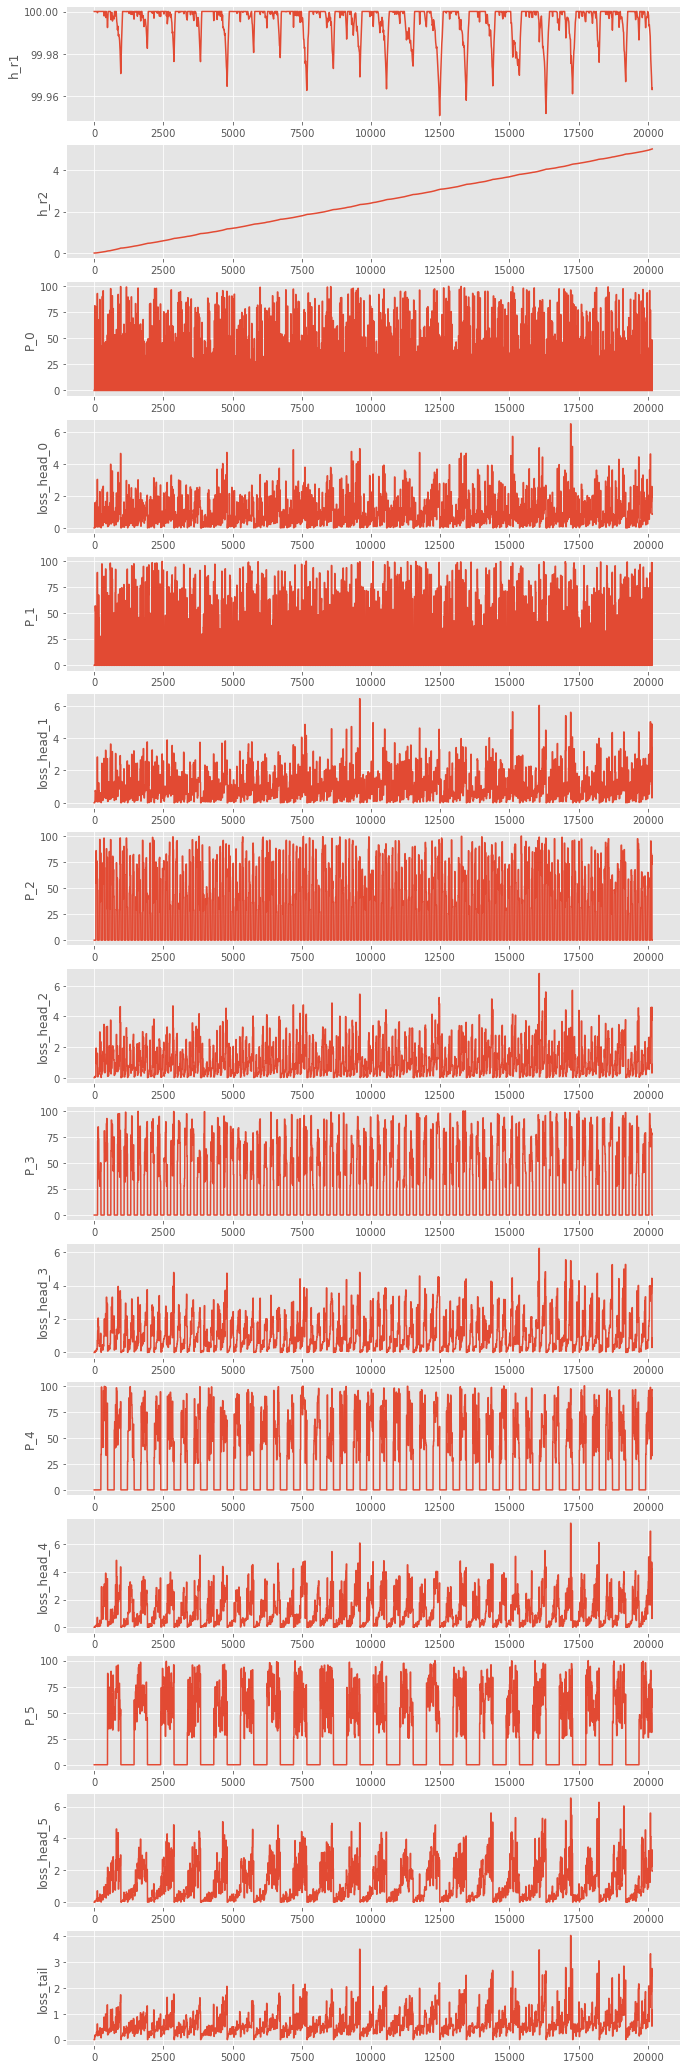

In [4]:
Nplots = len(variables)
jmin = 0      # minimum pixel number
jmax = -1      # maximum pixel number, set to -1 to include all
fig, axs = plt.subplots(Nplots, 1, figsize=(11,2.5*Nplots))

for i in range(Nplots):
    axs[i].plot(data[variables[i]].iloc[jmin:jmax])
    axs[i].set_ylabel(variables[i])   

### Additional visualisation and correlation
Normally we would always use a scatter plot and correlation matrix to check for dependencies and feature engineering, but in order to get to more interesting aspects, **today we will skip those steps**. The code is given below for future reference.

In [5]:
# Visualising data dependencies with seaborn, might take a while to run 
# Create the pairgrid object
#grid = sns.PairGrid(data=data, vars=variables, diag_sharey=False)

# Upper is a scatter plot
#grid.map_lower(plt.scatter, alpha=0.8, s=20)

# Diagonal is a histogram
#grid.map_diag(sns.kdeplot)
# Bottom is density plot
#grid.map_upper(sns.kdeplot)
#plt.savefig('/gridmap.pdf')
#plt.show()

Parameter correlation is a quick way to check which parameters are important for the analysis. A trained eye will spot the correlations from the gridplot above, but still a quantification can be useful. We use a Spearman correlation since we don't know if the relationship between parameters is linear (Pearson correlation assumes linearity), and we're not interested in absolute values of correlations but rather the relative correlation.

In [6]:
# Create correlation matrix
#corr_matrix = data[variables].corr(method='spearman')
# Plot
#fig, axs = plt.subplots(1, 1, figsize=(10, 10))
#sns.heatmap(abs(corr_matrix), annot=True, cmap = plt.cm.autumn_r, fmt='.2f', ax=axs)

### Feature engineering and input/output features
We will use the heights and the individual power productions as input features, and the losses as output features. Since we want to optimise on the total loss, we will add it as an additional feature.

In [7]:
loss_list = ['loss_head_0', 'loss_head_1', 'loss_head_2', 
             'loss_head_3', 'loss_head_4', 'loss_head_5', 'loss_tail']
data['loss_tot'] = data[loss_list].sum(axis=1)  # summing all losses in each row

In [8]:
X_feat = ['h_r1', 'h_r2', 'P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']
y_feat = ['loss_head_0', 'loss_head_1', 'loss_head_2', 
          'loss_head_3', 'loss_head_4', 'loss_head_5', 'loss_tail', 'loss_tot']
features = X_feat + y_feat

### Training and test data

Before we can train a model, we need to split the data in a training sample and a test sample.

We must also split out a sample to use for tuning the model. That is called the validation data. We want the validation to take place on chronological data rather than the randomized training data.

<span style="color:orange"> Chose the fraction of data to want to use for test and validation. </span>

In [9]:
train_frac = 0.2                # Fraction of total data for training
test_frac = 1 - train_frac      # Reserved for testing. Not used in training
val_frac = 0.2                  # Fraction of training data used during training for tuning of hyper parameters

In [10]:
train_split_index = int(train_frac*len(data))
val_split_index = int(val_frac*train_split_index) 
# We split out the validation data rather than using the validation_split variable in keras, since we want the 
# validation to take place on chronological data rather than the randomized training data

data_train = data.iloc[:train_split_index]
data_test = data.iloc[train_split_index:]
data_val = data.iloc[train_split_index-val_split_index:train_split_index]      

### Visualising the split (on the dependent features)

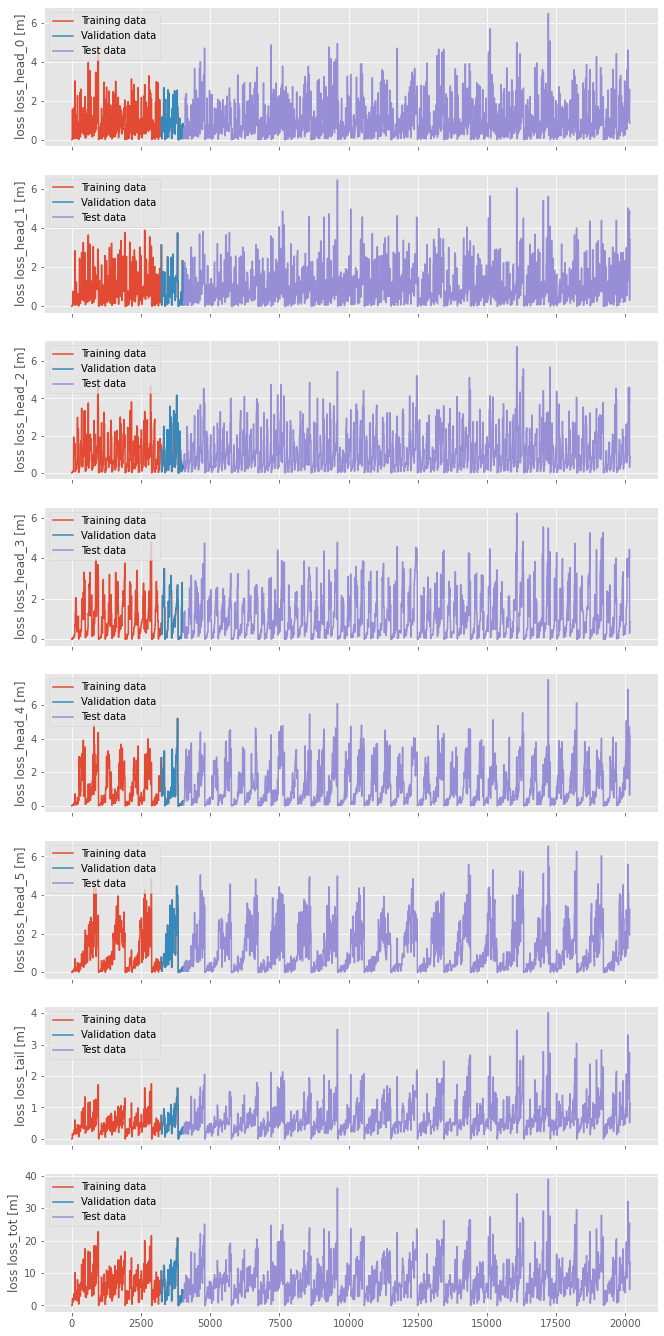

In [11]:
Nplots = len(y_feat)
fig, axs = plt.subplots(Nplots, 1, figsize=(11,3*Nplots), sharey=False, sharex=True)

for i in range(Nplots):
    axs[i].plot(data_train[y_feat[i]], label='Training data')
    axs[i].plot(data_val[y_feat[i]], label='Validation data')
    axs[i].plot(data_test[y_feat[i]], label='Test data')
    axs[i].set_ylabel(f'loss {y_feat[i]} [m]')
    axs[i].legend()
        

In [12]:
X_train = data_train[X_feat]#.values
y_train = data_train[y_feat]#.values
X_val = data_val[X_feat]#.values
y_val = data_val[y_feat]#.values
X_test = data_test[X_feat]#.values
y_test = data_test[y_feat]#.values

In [13]:
print(np.shape(X_train))

(4032, 8)


### Feature scaling
Not all features have the same scale: Some have values of the order of 1000s, and some are 0.1. In order to let them equally influence the model, we need to "put everything on the same scale". We can either scale everything to a fixed range of values (MinMaxScaler) or change the distribution to become a normalised Gaussian (StandardScaler).

Depending on the sample size, the test data can either be scaled with their own scaling (for large samples), or with the training sample (small samples). What to chose depends on how you would treat the actual data you will later use with the model.

In [14]:
# Feature scaling
sc_X = MinMaxScaler(feature_range=[0,1])
sc_y = MinMaxScaler(feature_range=[0,1])
X_val_scaled = pd.DataFrame(sc_X.fit_transform(X_val), columns=X_feat)
y_val_scaled = pd.DataFrame(sc_y.fit_transform(y_val), columns=y_feat)
X_train_scaled = pd.DataFrame(sc_X.fit_transform(X_train), columns=X_feat)
y_train_scaled = pd.DataFrame(sc_y.fit_transform(y_train), columns=y_feat)
X_test_scaled = pd.DataFrame(sc_X.transform(X_test), columns=X_feat)

## Neural network
<span style="color:orange"> Stop and wait for further instructions. </span>



### Defining the neural network
We use the keras framework with the Tensorflow backend to define the network (if you have no idea what that sentece was about, don't worry). 

The neural network itself will take the X-features as input and provide the y-estimates as output, but we also wrap it in a function that takes the number of neurons in each layer as input. The last parameter is dropout fraction which we apply to prevent overfitting.

In [15]:
def createModel(number_neurons1=10, number_neurons2=6, number_neurons3=4, dropout_frac=0.1):
    model = Sequential()
    model.add(Dense(units=number_neurons1, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_frac))  # Preventing overfitting
    model.add(Dense(units=number_neurons2, activation='relu'))
    model.add(Dropout(dropout_frac))  # Preventing overfitting
    model.add(Dense(units=number_neurons3, activation='relu'))
    model.add(Dropout(dropout_frac))  # Preventing overfitting
    model.add(Dense(units=y_train.shape[1], activation='linear'))

    model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')
    return model

<span style="color:orange"> Chose the size of each layer and the dropout fraction by changing the values of the function parameters in the function call. </span>

In [16]:
model = createModel(number_neurons1=10, number_neurons2=6, number_neurons3=4, dropout_frac=0.1)

2021-09-14 12:43:03.723339: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2021-09-14 12:43:03.757060: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2594000000 Hz
2021-09-14 12:43:03.759841: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fffee6c4380 executing computations on platform Host. Devices:
2021-09-14 12:43:03.760153: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>


### Visualisation of a neural network
If you want to visualise the neural network, you can e.g. use http://alexlenail.me/NN-SVG/index.html

### Training the model
This may take a couple of minutes if the network is large. The figure below shows the loss computed on the training sample and the validation sample. The loss is the quantity the neural network aims to minimize.

The relevant hyper parameters are:

Epochs: The number of times the weights in the network will be updated. The value should be large enough for the network to converge (minimize loss to a stable level). If you run the training again without redefining the network, the training will continue from the previous session.

Batch size: Determines the number of samples for cross-validation. Generally you should use as small a batch size as patience/available computing time allows for.

Callbacks: A smart way to plot the loss during training. Requires the aux_functions.py

<span style="color:orange"> Chose some values for the hyper parameters and train the network </span>

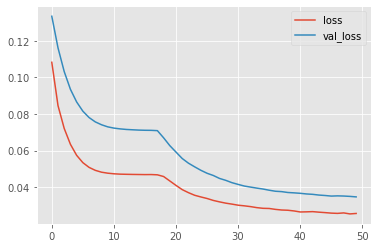

4032/4032 [==============================] - 0s 109us/sample - loss: 0.0257 - acc: 0.1696 - val_loss: 0.0347 - val_acc: 0.1675


In [17]:
training_history = model.fit(X_train_scaled, y_train_scaled, 
                             validation_data=(X_val_scaled, y_val_scaled), 
                             epochs=50,                  
                             batch_size=100,    
                             callbacks=[plot_losses])

### Using the model to predict the test data
Remember that we scaled the input and output data before training the model. Now we need to rescale the predictions before we compare to the actual values from the test data.

In [18]:
y_scaled = pd.DataFrame(model.predict(X_test_scaled), columns=y_feat)  # Predicting
y_pred = pd.DataFrame(sc_y.inverse_transform(y_scaled), columns=y_feat)  # Rescaling

### Plotting the results
Compare the predicted results with the test data y values. 

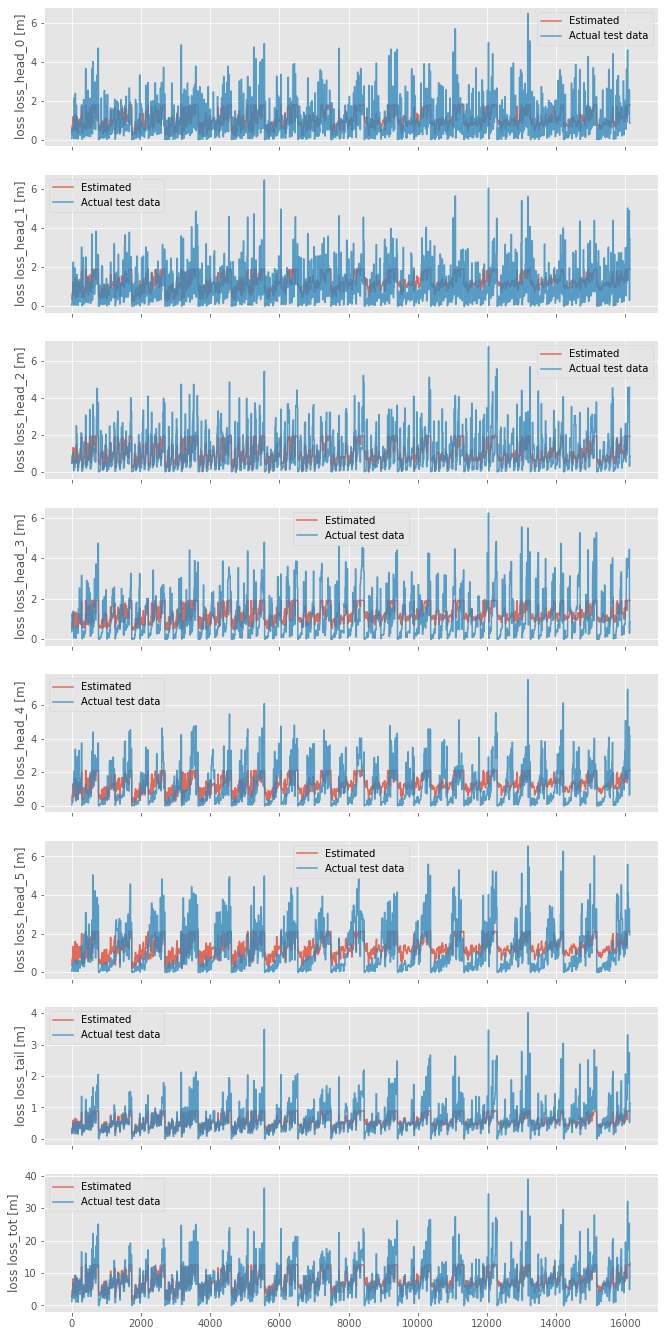

In [19]:
Nplots = len(y_feat)
fig, axs = plt.subplots(Nplots, 1, figsize=(11,3*Nplots), sharey=False, sharex=True)

for i in range(Nplots):
    axs[i].plot(y_pred[y_feat[i]].values, label = 'Estimated', alpha=0.8) #  '.'
    axs[i].plot(y_test[y_feat[i]].values, label = 'Actual test data', alpha=0.8)  #'.'
    axs[i].set_ylabel(f'loss {y_feat[i]} [m]')
    axs[i].legend()

It seems that the network tends to underestimate higher value and overstimate lower values. This is typical of an error-minimisation/least-squares approach.

## Optmisation with the neural network
<span style="color:orange"> Before you start this section, wait for further instructions. </span>

### Get the gradients
In order to optimise with the neural network, we need to get the gradients (derivatives) of the feature we would like to optimise, with respect to all the input features. We are here and in the following going to assume that `h_r1` and `h_r2` are constant, which is true enough if they are largely unaffected by what we do.

In [20]:
# This function may give a warning. Just ignore.
def get_gradients(model, inputs):
    features = tf.convert_to_tensor(inputs)
    with tf.GradientTape() as tape:
        tape.watch(features)
        predictions = model(features)
    gradients = tape.jacobian(predictions, features)
    return gradients

# Utility for visualizing optimization results
def plot_results(axs, init, found, obj):
    bound_palette = sns.dark_palette('brown')
    production_palette = sns.light_palette('green')
    turbine_palette = sns.color_palette()
    loss_palette = sns.light_palette('red')
    time_indices = np.array(range(obj.rows))
    
    for j in range(obj.free_cols):
        c = turbine_palette[j]
        axs[0].plot(time_indices, found[:,j], label=f'Turbine {j}', c = c)
        axs[0].plot(time_indices, init[:,j], c = c, linestyle = 'dotted')
    axs[0].legend(loc='upper left')
    axs[0].set_title('Production per turbine')
    
    # We will sum 
    axs[1].plot(time_indices, obj.lower_cons[:len(time_indices)], label='lower', c=bound_palette[0], linestyle='dotted')
    axs[1].plot(time_indices, obj.upper_cons[:len(time_indices)], label='upper', c=bound_palette[-1], linestyle='dotted')
    axs[1].plot(time_indices, init.sum(axis=1), label='orig prod', c=production_palette[2], linestyle='dashed')
    axs[1].plot(time_indices, found.sum(axis=1), label='opt prod', c=production_palette[-1])
    axs[1].legend(loc='upper left')
    axs[1].set_title('Total production')
    
    #This is a bit awkward, but no matter. The last output feature is total loss as seen above
    init_original_features = obj.to_internal(init.flatten())
    found_original_features = obj.to_internal(found.flatten())
    axs[2].plot(time_indices, obj.model(init_original_features).numpy()[:,-1], label ='orig loss', c = loss_palette[2], linestyle='dashed')
    axs[2].plot(time_indices, obj.model(found_original_features).numpy()[:,-1], label = 'opt loss', c = loss_palette[-1])
    axs[2].legend(loc='upper left')
    axs[2].set_title('Total loss')
    

### Simple optimization

The full code appears here, but as can be seen it is a little complex. The important part to understand is that we provide ipyopt with the objective and constraints, as well as their partial derivatives. 

<span style="color:orange"> For now, just execute the code... </span>

In [21]:
# We will be optimizing the pressures, but not the reservoir heights. They
# are assumed to be unaffected.

fixed_heights = X_test_scaled.values[:,:2]
initial_values = X_test_scaled.values[:,2:]

#We will also implement a basic class for this stuff
#Subclass must define constraints, jacobian, lower_bound, upper_bound, lower_cons, upper_cons, num_cons
class ModelBasedObjective(object):
    
    # Writing a more general handling of fixed columns is easy, but
    # ultimately unnecessary for us
    def __init__(self, rows, model, fixed, callback):
        self.rows = rows
        self.fixed_cols = 2
        self.free_cols = 6
        self.num_vars = self.rows * self.free_cols
        self.model = model
        self.fixed = fixed
        self.intermediate=callback
        
    def to_internal(self, xk):
        xk_shaped = xk.reshape(self.rows, self.free_cols)
        fixed = self.fixed[:self.rows,:]
        return np.concatenate((fixed, xk_shaped), axis=1)
    
    #Default adaptations if needed
    def objective(self, xk):
        return self.original_objective(self.to_internal(xk))
    
    def gradient(self, xk):
        return self._gradient(self.to_internal(xk))
    
    # Objective implementation
    def original_objective(self, x):
        objval = self.model(x).numpy()[:,-1].sum()
        return objval
    
    # Gradient implementation
    def _gradient(self, x):
        jacs = get_gradients(self.model, x)
        comb = jacs.numpy()[:,-1].sum(axis=0)[:,self.fixed_cols:]
        return comb.flatten()
    
def basic_callback(alg_mod, iter_count, obj_value, inf_pr, inf_du, mu, d_norm, regularization_size, alpha_du, alpha_pr, ls_trials):
        if iter_count % 10 == 0:
            print(f'Iteration {iter_count}, val={obj_value}. inf_pr, inf_du, mu: {inf_pr:.2f}, {inf_du:.2f}, {mu:.2f}')   

In [22]:
# Define a simple problem

class SimpleProblemSparse(ModelBasedObjective):
    
    def __init__(self, rows, model, fixed, callback, prod_lower, prod_upper):
        super().__init__(rows, model, fixed, callback)
        
        # Each constraint sums a single row of the x interpreted in 2d,
        # so each gradient is zero outside of a single row, but then
        # everything needs to be flattened to work with cyipopt
        #We also need to set the bounds
        self.lower_bound = np.array([0.0] * self.num_vars)
        self.upper_bound = np.array([1.0] * self.num_vars)
    
        self.lower_cons = np.array([prod_lower] * rows, dtype=np.float)
        self.upper_cons = np.array([prod_upper] * rows, dtype=np.float)
        self.num_cons = self.rows
        
        lx = []
        ly = []
        for i in range(self.rows):
            for j in range(self.free_cols):
                lx.append(i)
                ly.append(i * self.free_cols + j)

        self.jac_sparsity_indices = (np.array(lx), np.array(ly))
        
        self.jac = 1.0*np.ones(self.num_vars)
    
    def constraints(self, xk):
        x = xk.reshape(self.rows, self.free_cols)
        return x.sum(axis=1)
    
    def jacobian(self, xk):
        return self.jac
    
    def jacobianstructure(self):
        return self.jac_sparsity_indices

In [23]:
def optimize_model(obj, x0):  
    
    orig_obj = obj.objective(x0.flatten())
    
    print('Setting problem...')
    
    nlp = cyipopt.Problem(
                n = obj.num_vars,
                m = obj.num_cons,
                problem_obj = obj,
                lb = obj.lower_bound,
                ub = obj.upper_bound,
                cl = obj.lower_cons,
                cu = obj.upper_cons,
    )
    
    nlp.add_option('tol', 1e-2)
    print('Solving...')

    start = time.time()
    x, info = nlp.solve(x0.flatten())
    end = time.time()
    
    print(f'Initial value: {orig_obj}')
    print(f'Found value: {info["obj_val"]}')
    print(f'Status: {info["status"]}')
    print(f'Elapsed time: {end - start:.2f} seconds')
    
    #Reconstruct x with correct columns
    return x.reshape(obj.rows, obj.free_cols)

<span style="color:orange"> Try to change the lower or upper production values. </span>



Setting problem...
Solving...
Iteration 0, val=0.3551346957683563. inf_pr, inf_du, mu: 0.22, 0.08, 1.00

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       18
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       18
                     variables with only upper boun

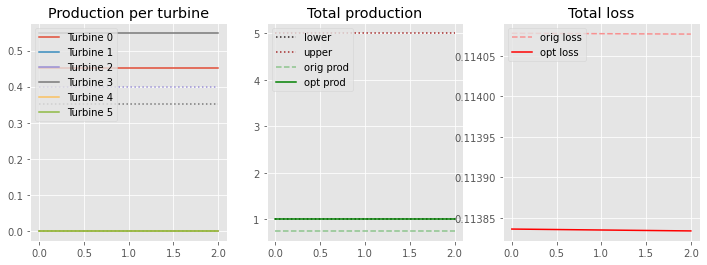

In [24]:
# Let's try with only three time steps first
tf.logging.set_verbosity(tf.logging.ERROR) #TODO remove this

rows = 3
init = initial_values[:rows,:]

obj = SimpleProblemSparse(rows, model, fixed_heights, basic_callback, 1.0, 5.0)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=0.3551346957683563. inf_pr, inf_du, mu: 0.22, 0.08, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       18
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       18
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        3
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(

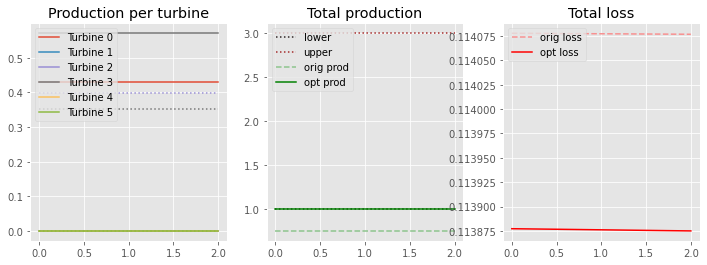

In [25]:
#Reduce upper
rows = 3
init = initial_values[:rows,:]

obj = SimpleProblemSparse(rows, model, fixed_heights, basic_callback, 1.0, 3.0)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

<span style="color:orange"> For a more interesting case, try with 60 time steps. </span>

Setting problem...
Solving...
Iteration 0, val=14.300719261169434. inf_pr, inf_du, mu: 0.22, 0.16, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      360
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(

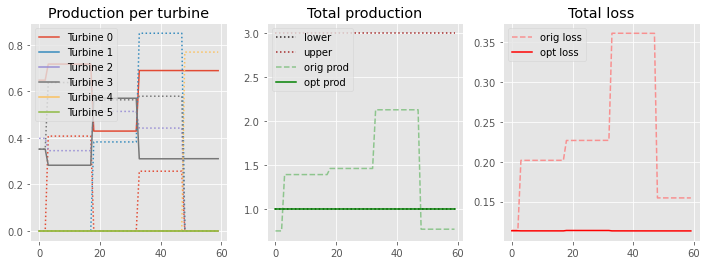

In [26]:
rows = 60
init = initial_values[:rows,:]

obj = SimpleProblemSparse(rows, model, fixed_heights, basic_callback, 1.0, 3.0)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=10.371208190917969. inf_pr, inf_du, mu: 0.00, 0.08, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      360
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(

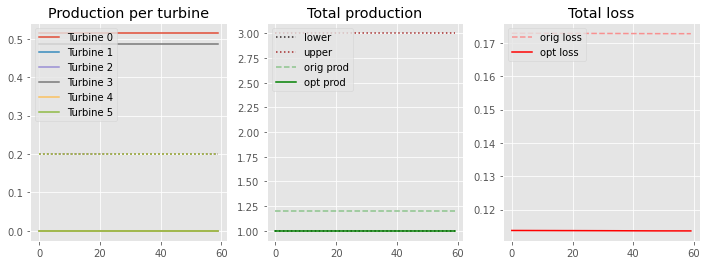

In [27]:
#Same with sparsity

rows = 60
init = 0.2*np.ones((60,6))

obj = SimpleProblemSparse(rows, model, fixed_heights, basic_callback, 1.0, 3.0)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

### With more realism

The model above is not realistic, for many reasons. We wish to extend the problem definition somewhat. Let's say we have a degree of flexibility in our production, so that we are rather trying to match the total historical production over the time frame. The problem is then to minimize the total loss, while producing at least this much (We will ignore time correction).

We can also add step constraints, and a time-varying production bound, but this will cause the model to be more complicated.

<span style="color:orange"> For now, just execute the code... </span>

In [28]:
# We will need to compute the historical production.
original_prod_per_time = initial_values.sum(axis=1)
# Now, for the first N time steps, the total production is original_prod_per_time[:N].sum()

In [29]:
# Utility for making sinusoidal production
def make_lower_prod(bottom, top, steps):
    args = np.arange(0,2*np.pi, step = 2*np.pi/steps)
    prod = ((1 - np.cos(args))/2.0) * (top - bottom) + bottom
    return prod

class TotalProductionBoundSparse(ModelBasedObjective):
    
    def __init__(self, rows, model, fixed, callback, prod_lower, prod_upper, total_prod):
        super().__init__(rows, model, fixed, callback)
        
        self.lower_bound = np.array([0.0] * self.num_vars)
        self.upper_bound = np.array([1.0] * self.num_vars)
    
        self.lower_cons = np.array([prod_lower] * rows + [total_prod], dtype=np.float)
        self.upper_cons = np.array([prod_upper] * rows + [self.free_cols * self.rows], dtype=np.float)
        self.num_cons = self.rows + 1
        
        lx = []
        ly = []
        for i in range(self.rows):
            for j in range(self.free_cols):
                lx.append(i)
                ly.append(i * self.free_cols + j)
        # Now append the last row, which has an index for every variable
        for i in range(self.rows):
            for j in range(self.free_cols):
                lx.append(self.rows)
                ly.append(i * self.free_cols + j)

        self.jac_sparsity_indices = (np.array(lx), np.array(ly))
        self.jac = np.concatenate((1.0*np.ones(self.num_vars), 1.0*np.ones(self.num_vars)))
    
    def constraints(self, xk):
        x = xk.reshape(self.rows, self.free_cols)
        return np.concatenate((x.sum(axis=1), [x.sum()]))
    
    def jacobian(self, xk):
        return self.jac
    
    def jacobianstructure(self):
        return self.jac_sparsity_indices


<span style="color:orange"> Experiment with different conditions </span>

Setting problem...
Solving...
Iteration 0, val=14.300719261169434. inf_pr, inf_du, mu: 0.00, 0.16, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      720
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      360
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       61
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       61
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(

  76  1.0257594e+01 0.00e+00 2.10e-01  -9.8 2.12e-03    -  1.00e+00 8.40e-02f  1
  77  1.0257565e+01 0.00e+00 2.14e-01 -11.0 3.75e-04    -  9.72e-01 2.43e-01f  3
  78  1.0257544e+01 0.00e+00 7.08e-02  -8.7 2.82e-04    -  4.53e-02 2.02e-01f  1
  79  1.0257527e+01 0.00e+00 2.00e-01  -9.4 7.71e-05    -  1.00e+00 5.00e-01f  2
Iteration 80, val=10.257516860961914. inf_pr, inf_du, mu: 0.00, 0.09, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.0257517e+01 0.00e+00 8.72e-02  -7.4 1.04e-04    -  8.52e-01 3.77e-01f  1
  81  1.0257519e+01 0.00e+00 1.18e+00  -6.3 1.46e-04    -  1.00e+00 2.50e-01f  3
  82  1.0257513e+01 0.00e+00 2.05e-01  -6.3 7.60e-05    -  1.00e+00 5.00e-01f  2
  83  1.0257515e+01 0.00e+00 2.18e-01  -5.5 2.68e-04    -  1.00e+00 2.50e-01f  3
  84  1.0257510e+01 0.00e+00 6.72e-02  -5.6 2.95e-04    -  1.00e+00 2.50e-01f  3
  85  1.0258257e+01 0.00e+00 1.17e+00  -4.1 9.98e-04    -  1.00e+00 1.00e+00f  1
  86  1.0258196e+01 0.00e+00 6.74e

 161  1.0257300e+01 0.00e+00 2.31e-01 -11.0 6.38e-06    -  1.00e+00 2.50e-01f  3
 162  1.0257300e+01 0.00e+00 2.16e-01 -11.0 4.36e-06    -  1.00e+00 5.00e-01f  2
 163  1.0257300e+01 0.00e+00 2.06e-01 -11.0 4.48e-06    -  1.00e+00 1.00e+00f  1
 164  1.0257299e+01 0.00e+00 2.08e-01 -11.0 6.60e-06    -  1.00e+00 1.00e+00f  1
 165  1.0257298e+01 0.00e+00 7.17e-02 -11.0 1.09e-05    -  1.00e+00 2.50e-01f  3
 166  1.0257298e+01 0.00e+00 7.19e-02 -11.0 1.29e-05    -  1.00e+00 3.91e-03f  9
 167  1.0257298e+01 0.00e+00 7.21e-02 -11.0 5.34e-06    -  1.00e+00 3.12e-02f  6
 168  1.0257298e+01 0.00e+00 7.24e-02 -11.0 7.64e-06    -  1.00e+00 1.56e-02f  7
 169  1.0257298e+01 0.00e+00 7.30e-02 -11.0 2.25e-05    -  1.00e+00 3.12e-02f  6
Iteration 170, val=10.25729751586914. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.0257298e+01 0.00e+00 6.88e-02 -11.0 4.73e-06    -  1.00e+00 1.00e+00f  1
 171  1.0257298e+01 0.00e+00 7.12e

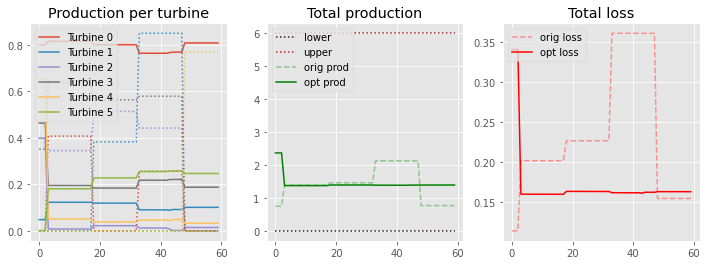

In [30]:
#Strict curve
rows = 60
init = initial_values[:rows,:]

obj = TotalProductionBoundSparse(rows, model, fixed_heights, basic_callback, 0.0, 6.0, original_prod_per_time[:rows].sum())
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=24.957988739013672. inf_pr, inf_du, mu: 0.00, 0.20, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      720
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      360
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       61
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       61
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(

  76  1.0286385e+01 0.00e+00 7.05e-02  -3.1 2.46e-02    -  1.00e+00 2.50e-01f  3
  77  1.0288788e+01 0.00e+00 6.74e-02  -3.1 1.79e-02    -  1.00e+00 5.00e-01f  2
  78  1.0291474e+01 0.00e+00 7.21e-02  -3.1 2.61e-02    -  1.00e+00 5.00e-01f  2
  79  1.0291805e+01 0.00e+00 6.27e-02  -3.1 3.20e-02    -  1.00e+00 2.50e-01f  3
Iteration 80, val=10.28847599029541. inf_pr, inf_du, mu: 0.00, 0.06, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.0288476e+01 0.00e+00 6.34e-02  -3.1 1.05e-02    -  1.00e+00 1.00e+00f  1
  81  1.0287373e+01 0.00e+00 6.36e-02  -3.1 2.37e-02    -  1.00e+00 1.25e-01f  4
  82  1.0287294e+01 0.00e+00 6.64e-02  -3.1 1.09e-02    -  1.00e+00 1.25e-01f  4
  83  1.0286799e+01 0.00e+00 6.45e-02  -3.1 4.61e-03    -  1.00e+00 1.00e+00f  1
  84  1.0286868e+01 0.00e+00 7.02e-02  -3.1 6.55e-03    -  1.00e+00 5.00e-01f  2
  85  1.0286401e+01 0.00e+00 6.65e-02  -3.1 7.72e-03    -  1.00e+00 5.00e-01f  2
  86  1.0286210e+01 0.00e+00 7.26e-

 161  1.0282993e+01 0.00e+00 7.54e-02  -3.1 2.64e-05    -  1.00e+00 1.00e+00f  1
 162  1.0282991e+01 0.00e+00 7.23e-02  -3.1 1.73e-05    -  1.00e+00 5.00e-01f  2
 163  1.0282991e+01 0.00e+00 7.91e-02  -3.1 6.39e-06    -  1.00e+00 1.00e+00f  1
 164  1.0282991e+01 0.00e+00 7.91e-02  -3.1 6.52e-06    -  1.00e+00 1.53e-05h 17
 165  1.0282991e+01 0.00e+00 7.91e-02  -3.1 6.52e-06    -  1.00e+00 5.82e-11h 35
 166  1.0282991e+01 0.00e+00 7.91e-02  -3.1 6.52e-06    -  1.00e+00 2.91e-11h 36
 167  1.0282991e+01 0.00e+00 8.71e-02  -3.1 4.96e-01    -  5.42e-01 3.81e-06f 19
 168  1.0282991e+01 0.00e+00 8.61e-02  -3.1 1.42e-05    -  1.00e+00 7.45e-09h 28
 169  1.0282990e+01 0.00e+00 6.92e-02  -3.1 1.42e-05    -  1.00e+00 1.00e+00S 59
Iteration 170, val=10.282989501953125. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.0282990e+01 0.00e+00 6.92e-02  -3.1 2.86e-06    -  1.00e+00 1.46e-11h 37
 171  1.0282990e+01 0.00e+00 6.92

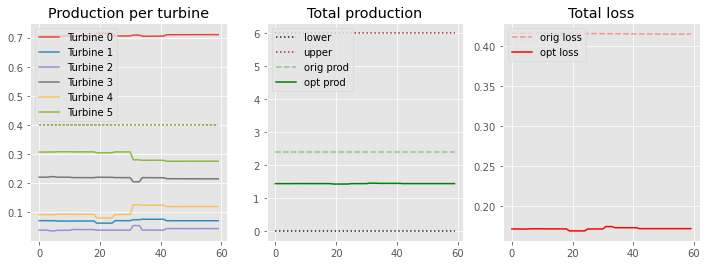

In [31]:
rows = 60
init = 0.4* np.ones((rows, 6))

obj = TotalProductionBoundSparse(rows, model, fixed_heights, basic_callback, 0.0, 6.0, original_prod_per_time[:rows].sum())
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

In [32]:
# Define a simple problem

class TimeVaryingProductionBound(ModelBasedObjective):
    
    def __init__(self, rows, model, fixed, callback, prod_lower, prod_upper):
        super().__init__(rows, model, fixed, callback)
        
        # Each constraint sums a single row of the x interpreted in 2d,
        # so each gradient is zero outside of a single row, but then
        # everything needs to be flattened to work with cyipopt
        #We also need to set the bounds
        self.lower_bound = np.array([0.0] * self.num_vars)
        self.upper_bound = np.array([1.0] * self.num_vars)
    
        self.lower_cons = prod_lower
        self.upper_cons = prod_upper
        self.num_cons = self.rows
        
        lx = []
        ly = []
        for i in range(self.rows):
            for j in range(self.free_cols):
                lx.append(i)
                ly.append(i * self.free_cols + j)

        self.jac_sparsity_indices = (np.array(lx), np.array(ly))
        
        self.jac = 1.0*np.ones(self.num_vars)
    
    def constraints(self, xk):
        x = xk.reshape(self.rows, self.free_cols)
        return x.sum(axis=1)
    
    def jacobian(self, xk):
        return self.jac
    
    def jacobianstructure(self):
        return self.jac_sparsity_indices

Setting problem...
Solving...
Iteration 0, val=24.957988739013672. inf_pr, inf_du, mu: 0.00, 0.18, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      360
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(

  75  1.0968254e+01 0.00e+00 8.47e-02  -3.2 4.15e-03    -  1.00e+00 1.00e+00f  1
  76  1.0965539e+01 0.00e+00 7.28e-02  -3.2 2.60e-03    -  1.00e+00 1.00e+00f  1
  77  1.0966875e+01 0.00e+00 7.36e-02  -3.2 2.53e-03    -  1.00e+00 1.00e+00f  1
  78  1.0966448e+01 0.00e+00 6.77e-02  -3.2 2.69e-03    -  1.00e+00 5.00e-01f  2
  79  1.0967560e+01 0.00e+00 8.28e-02  -3.2 1.45e-03    -  1.00e+00 1.00e+00f  1
Iteration 80, val=10.966846466064453. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.0966846e+01 0.00e+00 7.31e-02  -3.2 1.52e-03    -  1.00e+00 1.00e+00f  1
  81  1.0966222e+01 0.00e+00 7.91e-02  -3.2 1.24e-03    -  1.00e+00 5.00e-01f  2
  82  1.0966041e+01 0.00e+00 7.63e-02  -3.2 1.09e-03    -  1.00e+00 1.00e+00f  1
  83  1.0967550e+01 0.00e+00 6.69e-02  -3.2 1.30e-03    -  1.00e+00 1.00e+00f  1
  84  1.0967500e+01 0.00e+00 7.45e-02  -3.2 1.36e-03    -  1.00e+00 5.00e-01f  2
  85  1.0966599e+01 0.00e+00 7.83e

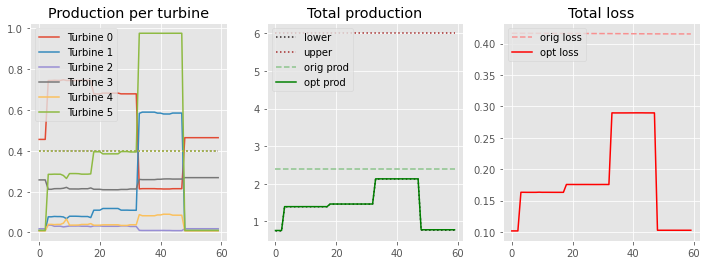

In [33]:
# Historically accurate production
rows = 60
init = 0.4 * np.ones((rows,6))

obj = TimeVaryingProductionBound(rows, model, fixed_heights, basic_callback, 
                                original_prod_per_time[:rows], [6.0] * rows)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=14.300719261169434. inf_pr, inf_du, mu: 0.00, 0.16, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      360
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(

  76  1.1031855e+01 0.00e+00 6.96e-02  -3.3 5.09e-06    -  1.00e+00 5.00e-01f  2
  77  1.1031853e+01 0.00e+00 6.93e-02  -3.3 3.68e-05    -  1.00e+00 3.12e-02f  6
  78  1.1031853e+01 0.00e+00 6.93e-02  -3.3 6.08e-05    -  1.00e+00 2.38e-07h 23
  79  1.1031853e+01 0.00e+00 6.93e-02  -3.3 6.08e-05    -  1.00e+00 9.31e-10h 31
Iteration 80, val=11.031852722167969. inf_pr, inf_du, mu: 0.00, 0.07, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.1031853e+01 0.00e+00 6.93e-02  -3.3 6.08e-05    -  1.00e+00 7.28e-12h 38
  81  1.1031853e+01 0.00e+00 7.63e-02  -3.3 6.00e-02    -  1.00e+00 3.05e-05f 16
  82  1.1031853e+01 0.00e+00 6.86e-02  -3.3 9.03e-06    -  1.00e+00 1.22e-04h 14
  83  1.1031853e+01 0.00e+00 6.86e-02  -3.3 9.04e-06    -  1.00e+00 1.22e-04h 14
  84  1.1031853e+01 0.00e+00 6.86e-02  -3.3 9.04e-06    -  1.00e+00 1.22e-04h 14
  85  1.1098264e+01 0.00e+00 9.64e-02  -3.3 6.00e-02    -  1.00e+00 1.00e+00w  1
  86  1.1056415e+01 0.00e+00 6.63e

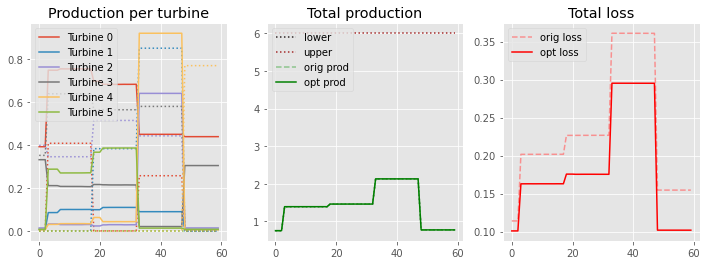

In [34]:
# Historically accurate production
rows = 60
init = initial_values[:rows,:]

obj = TimeVaryingProductionBound(rows, model, fixed_heights, basic_callback, 
                                original_prod_per_time[:rows], [6.0] * rows)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

## Evaluation of model performance
<span style="color:orange"> Before you start this section, wait for further instructions. </span>

### Evaluating the cross-validation scores
One way to quantify if the neural network provides a reasonable fit is to compute the mean squared error on multiple splots of the test data (cross-validation). ScikitLearn has a function for that, which returns the score for each of the data splits. If the mean squared error is small, the model is a good fit to the data. If the variation is small, the model has also managed to generalise the information in the data. (For technical reasons ScikitLearn uses negative mean squared error).

<span style="color:orange"> Is your model good? </span>

In [35]:
scores = cross_val_score(KerasRegressor(build_fn=createModel, nb_epoch=30, verbose=0), 
                         X_test_scaled, y_test,  cv=5, scoring="neg_mean_squared_error")
print(scores*-1)

[ 1.3103559  12.70748361  2.01477631  3.01276314  3.19073261]


## Hyperparameter optimization
<span style="color:orange"> Before you start this section, wait for further instructions. </span>

### Manual

<span style="color:orange"> Try different values for the hyper parameters by replacing the values below </span>

In [36]:
dropout_frac = 0      # fraction between 0 and 1
number_neurons1 = 5   # integer
number_neurons2 = 6   # integer
number_neurons3 = 7   # integer

In [37]:
model2 = createModel(dropout_frac=dropout_frac, 
                     number_neurons1=number_neurons1, 
                     number_neurons2=number_neurons2, 
                     number_neurons3=number_neurons3)

### Randomized search
Manually searching through hyper parameters isn't very effective. Instead we will use an option called randomized search, where we specify some ranges for the hyper parameters.

<span style="color:orange"> Set some ranges for the layer sizes and search through the hyper parameter space. This may take a while, so we just run a very small grid with few iterations and cross-validations. </span>

In [38]:
param_dist = {"number_neurons1": randint(4, 6),
              "number_neurons2": randint(7, 8),
              "number_neurons3": randint(4, 6),
              "dropout_frac": [0, 0.1, 0.2]}

In [39]:
# In order to use randomized searh we need to define our model as a regressor
k_model = KerasRegressor(build_fn=createModel, verbose=0)

In [40]:
# Define the search
random_search = RandomizedSearchCV(k_model, param_distributions=param_dist,                   
                                   scoring = "neg_mean_squared_error",
                                   n_iter=1, cv=2)

In [41]:
# Run the search
random_search.fit(X_train_scaled, y_train_scaled,
                  validation_data=(X_val_scaled, y_val_scaled),
                  epochs=30, batch_size=100, verbose=2)

Train on 2016 samples, validate on 806 samples
Epoch 1/30
2016/2016 - 0s - loss: 0.1835 - acc: 0.1409 - val_loss: 0.1855 - val_acc: 0.1055
Epoch 2/30
2016/2016 - 0s - loss: 0.1319 - acc: 0.1101 - val_loss: 0.1538 - val_acc: 0.0955
Epoch 3/30
2016/2016 - 0s - loss: 0.1070 - acc: 0.1027 - val_loss: 0.1364 - val_acc: 0.0546
Epoch 4/30
2016/2016 - 0s - loss: 0.0929 - acc: 0.1106 - val_loss: 0.1245 - val_acc: 0.0484
Epoch 5/30
2016/2016 - 0s - loss: 0.0832 - acc: 0.1136 - val_loss: 0.1146 - val_acc: 0.0596
Epoch 6/30
2016/2016 - 0s - loss: 0.0755 - acc: 0.1086 - val_loss: 0.1066 - val_acc: 0.0471
Epoch 7/30
2016/2016 - 0s - loss: 0.0693 - acc: 0.1081 - val_loss: 0.0993 - val_acc: 0.0645
Epoch 8/30
2016/2016 - 0s - loss: 0.0637 - acc: 0.1195 - val_loss: 0.0928 - val_acc: 0.1104
Epoch 9/30
2016/2016 - 0s - loss: 0.0589 - acc: 0.1597 - val_loss: 0.0874 - val_acc: 0.0931
Epoch 10/30
2016/2016 - 0s - loss: 0.0555 - acc: 0.1424 - val_loss: 0.0832 - val_acc: 0.0744
Epoch 11/30
2016/2016 - 0s - los

Epoch 28/30
4032/4032 - 0s - loss: 0.0190 - acc: 0.0250 - val_loss: 0.0303 - val_acc: 0.0360
Epoch 29/30
4032/4032 - 0s - loss: 0.0190 - acc: 0.0250 - val_loss: 0.0303 - val_acc: 0.0360
Epoch 30/30
4032/4032 - 0s - loss: 0.0189 - acc: 0.0250 - val_loss: 0.0301 - val_acc: 0.0360


RandomizedSearchCV(cv=2,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f769d036610>,
                   n_iter=1,
                   param_distributions={'dropout_frac': [0, 0.1, 0.2],
                                        'number_neurons1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f769d011050>,
                                        'number_neurons2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f769d011e10>,
                                        'number_neurons3': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f769d036110>},
                   scoring='neg_mean_squared_error')

In [42]:
# Print the best score from the random search
random_search.best_score_*-1

0.028125725961366047

<span style="color:orange"> Compare to the score you got for manual search </span>

In [43]:
# Print the best parameters
random_search.best_params_

{'dropout_frac': 0,
 'number_neurons1': 4,
 'number_neurons2': 7,
 'number_neurons3': 4}

<span style="color:orange"> Compare to the network sizes you had before. Is the fit better now? </span>

In reality we would run a larger grid, so if you didn't get any improvement, you can try with 

best_params = {'dropout_frac': 0.1, 'number_neurons1': 18, 'number_neurons2': 10, 'number_neurons3': 12}

### Visualising the new model

In [44]:
y_scaled = pd.DataFrame(random_search.predict(X_test_scaled), columns=y_feat)  # Predicting
y_pred = pd.DataFrame(sc_y.inverse_transform(y_scaled), columns=y_feat)  # Rescaling

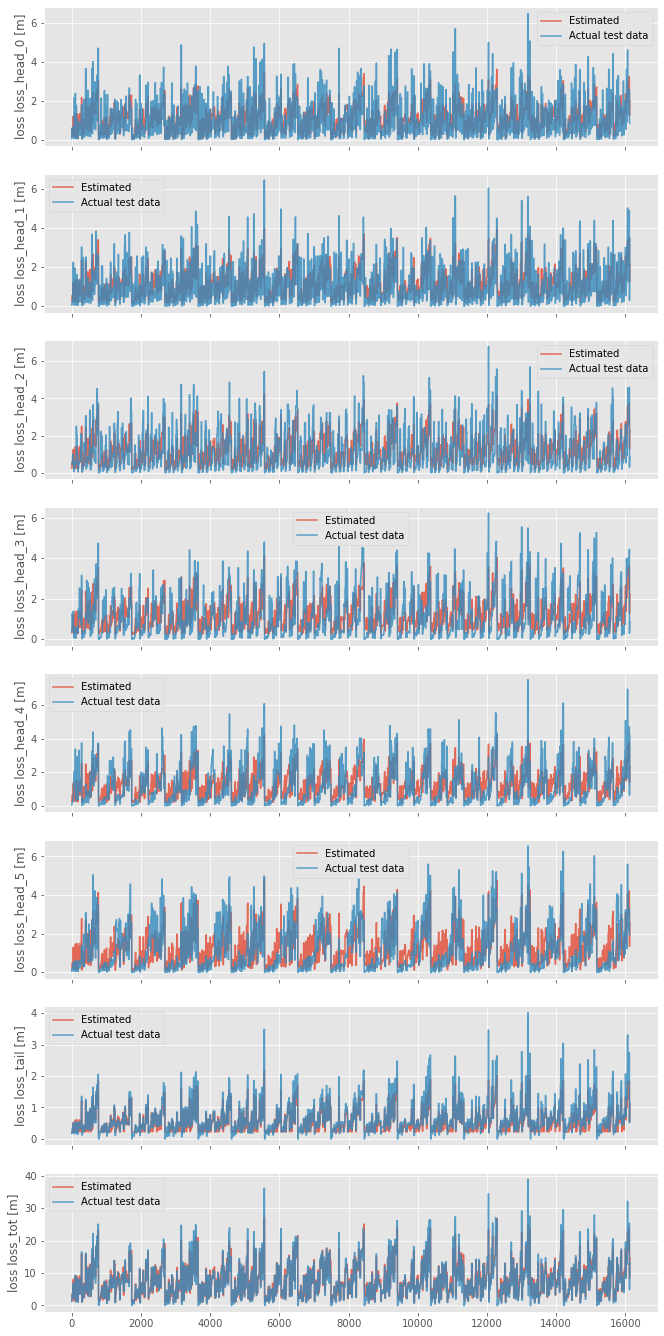

In [45]:
Nplots = len(y_feat)
fig, axs = plt.subplots(Nplots, 1, figsize=(11,3*Nplots), sharey=False, sharex=True)

for i in range(Nplots):
    axs[i].plot(y_pred[y_feat[i]].values, label = 'Estimated', alpha=0.8) 
    axs[i].plot(y_test[y_feat[i]].values, label = 'Actual test data', alpha=0.8)     
    axs[i].set_ylabel(f'loss {y_feat[i]} [m]')
    axs[i].legend()

## Optimisation with better model

Let's try this again.

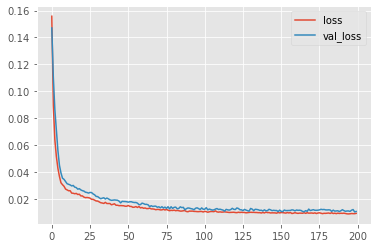

4032/4032 [==============================] - 0s 78us/sample - loss: 0.0094 - acc: 0.6481 - val_loss: 0.0108 - val_acc: 0.5943


In [46]:
# We must train a model with the best hyperparameters from the random search
#model2 = createModel(dropout_frac=random_search.best_params_['dropout_frac'], 
#                     number_neurons1=random_search.best_params_['number_neurons1'],
#                     number_neurons2=random_search.best_params_['number_neurons2'],
#                     number_neurons3=random_search.best_params_['number_neurons3'])

dropout_frac = 0.1      # fraction between 0 and 1
number_neurons1 = 18   # integer
number_neurons2 = 10   # integer
number_neurons3 = 12   # integer

model2 = createModel(dropout_frac=dropout_frac, 
                     number_neurons1=number_neurons1, 
                     number_neurons2=number_neurons2, 
                     number_neurons3=number_neurons3)

training_history = model2.fit(X_train_scaled, y_train_scaled, 
                             validation_data=(X_val_scaled, y_val_scaled), 
                             epochs=200,                  
                             batch_size=100,    
                             callbacks=[plot_losses])

<span style="color:orange"> Try some of the same snippets as before. Are the results different? </span>

Setting problem...
Solving...
Iteration 0, val=18.108694076538086. inf_pr, inf_du, mu: 0.00, 0.27, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      720
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      360
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       61
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       61
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(

  76  4.2011604e+00 0.00e+00 3.22e-01 -11.0 1.08e-03    -  1.00e+00 5.00e-01f  2
  77  4.2004123e+00 0.00e+00 1.44e-01 -11.0 1.43e-03    -  1.00e+00 6.40e-01f  1
  78  4.2001910e+00 0.00e+00 3.21e-01 -11.0 7.69e-03    -  1.00e+00 1.80e-01f  2
  79  4.1993213e+00 0.00e+00 2.46e-01  -9.0 1.95e-02    -  7.56e-01 5.95e-02f  1
Iteration 80, val=4.199300765991211. inf_pr, inf_du, mu: 0.00, 0.25, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  4.1993008e+00 0.00e+00 2.46e-01 -10.1 2.96e-02    -  1.00e+00 3.60e-04f  1
  81  4.1987610e+00 0.00e+00 2.47e-01  -8.1 1.43e-02    -  1.00e+00 2.30e-02f  1
  82  4.1985517e+00 0.00e+00 2.47e-01  -9.5 8.19e-03    -  1.00e+00 1.30e-02f  1
  83  4.1980152e+00 0.00e+00 3.20e-01 -11.0 9.43e-03    -  1.00e+00 1.59e-01f  1
  84  4.1978226e+00 0.00e+00 3.20e-01  -6.9 1.47e-02    -  1.00e+00 6.56e-03f  1
  85  4.1968312e+00 0.00e+00 2.33e+00  -4.9 3.19e-01    -  2.94e-01 1.33e-02f  1
  86  4.1963806e+00 0.00e+00 1.41e+

 161  4.1915073e+00 0.00e+00 2.45e-01 -11.0 4.24e-01  -0.5 4.14e-04 2.25e-04w  1
 162  4.1915073e+00 0.00e+00 2.45e-01 -11.0 7.04e-01    -  6.55e-04 2.25e-06w  1
 163  4.1914983e+00 0.00e+00 2.45e-01 -11.0 2.13e-01    -  2.63e-03 3.14e-04w  1
Initial value: 18.108694076538086Cannot call restoration phase at point that is almost feasible (violation 0.000000e+00).
Abort in line search due to no other fall back.

Number of Iterations....: 163

                                   (scaled)                 (unscaled)
Objective...............:   4.1910057067871094e+00    4.1910057067871094e+00
Dual infeasibility......:   1.2880042835667402e-01    1.2880042835667402e-01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   8.1369963655871218e-09    8.1369963655871218e-09
Complementarity.........:   1.3304432317214792e-11    1.3304432317214792e-11
Overall NLP error.......:   1.2880042835667402e-01    1.2880042835667402e-01


Number of objective 

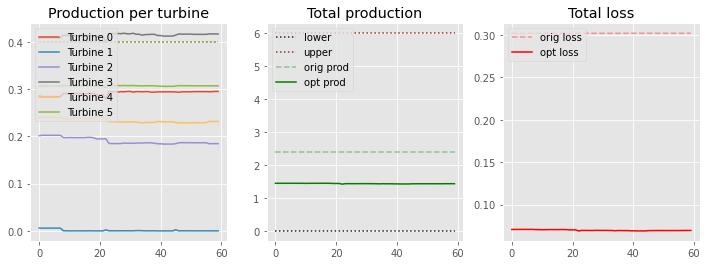

In [47]:
# With total production bound

rows = 60
init = 0.4* np.ones((rows, 6))

obj = TotalProductionBoundSparse(rows, model2, fixed_heights, basic_callback, 0.0, 6.0, original_prod_per_time[:rows].sum())
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=18.108694076538086. inf_pr, inf_du, mu: 0.00, 0.23, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      360
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      360
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(

  76  5.3116980e+00 0.00e+00 2.44e-01 -11.0 2.08e-05    -  1.00e+00 2.76e-01f  2
In iteration 76, 1 Slack too small, adjusting variable bound
  77  5.3116913e+00 0.00e+00 2.24e-01 -11.0 6.40e-06    -  1.00e+00 5.12e-01f  1
  78  5.3116913e+00 0.00e+00 2.22e-01 -11.0 8.06e-06    -  1.00e+00 1.00e+00f  1
In iteration 78, 1 Slack too small, adjusting variable bound
  79  5.3116856e+00 0.00e+00 2.29e-01 -11.0 4.63e-06    -  1.00e+00 5.20e-01f  1
Iteration 80, val=5.311681747436523. inf_pr, inf_du, mu: 0.00, 0.24, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  5.3116817e+00 0.00e+00 2.37e-01 -11.0 8.43e-06    -  1.00e+00 3.47e-01f  2
  81  5.3116770e+00 0.00e+00 2.81e-01 -11.0 3.03e-06    -  1.00e+00 1.00e+00f  1
  82  5.3116751e+00 0.00e+00 2.16e-01 -11.0 8.88e-06    -  1.00e+00 3.36e-01f  2
In iteration 82, 1 Slack too small, adjusting variable bound
  83  5.3116732e+00 0.00e+00 2.35e-01 -11.0 4.25e-06    -  1.00e+00 2.49e-01f  1
  84  5.311672

In iteration 151, 1 Slack too small, adjusting variable bound
 152  5.3116837e+00 0.00e+00 2.48e-01 -10.3 4.61e-05    -  1.50e-01 1.42e-01w  1
 153  5.3116589e+00 0.00e+00 4.42e-01 -10.3 2.93e-06    -  1.00e+00 8.10e-06h 15
 154  5.3116589e+00 0.00e+00 2.87e-01 -10.3 1.82e-04    -  7.05e-01 9.27e-09h 27
 155  5.3116589e+00 0.00e+00 2.95e-01 -10.3 1.89e-04    -  5.66e-02 7.45e-09h 28
 156  5.3116589e+00 0.00e+00 2.74e-01 -10.3 3.06e-04    -  1.29e-01 2.33e-10h 33
 157  5.3116589e+00 0.00e+00 2.37e-01 -10.3 2.23e-01    -  2.97e-01 3.05e-13f 40
 158  5.3116589e+00 0.00e+00 2.23e-01 -10.3 2.23e-01    -  1.00e+00 4.38e-14f 43
 159  5.3116589e+00 0.00e+00 2.23e-01 -10.3 2.23e-01    -  2.97e-01 1.10e-14f 45
Iteration 160, val=5.31165885925293. inf_pr, inf_du, mu: 0.00, 0.22, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.3116589e+00 0.00e+00 2.23e-01 -10.3 2.23e-01    -  1.00e+00 5.48e-15f 46
 161  5.3116589e+00 0.00e+00 2.23e-01 -10.3 2.23e-01  

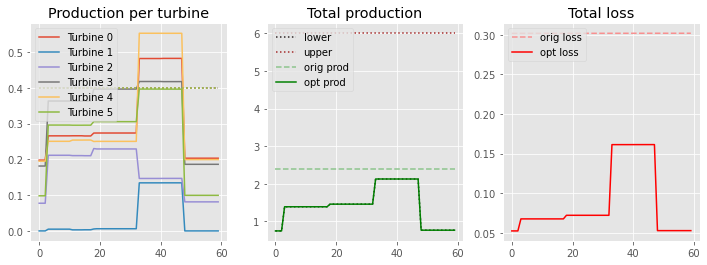

In [48]:
# Historically accurate production, starting from 0.4
rows = 60
init = 0.4 * np.ones((rows,6))

obj = TimeVaryingProductionBound(rows, model2, fixed_heights, basic_callback, 
                                original_prod_per_time[:rows], [6.0] * rows)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=24.363922119140625. inf_pr, inf_du, mu: 0.00, 0.20, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      720
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      720
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      720
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      120
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(

  76  1.2845800e+01 0.00e+00 2.57e-01 -10.3 2.52e-04    -  1.00e+00 1.76e-01f  2
  77  1.2845722e+01 0.00e+00 2.32e-01  -8.8 2.02e-04    -  1.00e+00 4.42e-01f  1
  78  1.2845631e+01 0.00e+00 2.49e-01  -6.5 3.99e-04    -  9.68e-01 3.19e-01f  1
  79  1.2845574e+01 0.00e+00 2.38e-01 -11.0 1.17e-03    -  4.57e-01 1.94e-02f  1
Iteration 80, val=12.845340728759766. inf_pr, inf_du, mu: 0.00, 0.25, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.2845341e+01 0.00e+00 2.47e-01  -5.3 1.35e-02    -  3.07e-01 2.89e-02f  1
  81  1.2847196e+01 0.00e+00 2.47e-01  -5.1 4.16e-03    -  7.91e-01 5.00e-01f  2
  82  1.2846350e+01 0.00e+00 2.42e-01  -5.3 4.98e-03    -  8.00e-01 3.31e-01f  2
  83  1.2845964e+01 0.00e+00 3.06e-01  -5.3 6.50e-03    -  1.00e+00 1.73e-01f  3
  84  1.2845672e+01 0.00e+00 3.06e-01  -5.3 4.43e-03    -  7.06e-01 4.75e-01f  2
  85  1.2844524e+01 0.00e+00 2.48e-01  -5.3 9.21e-04    -  1.00e+00 1.00e+00f  1
  86  1.2843759e+01 0.00e+00 2.49e

 161  1.2838628e+01 0.00e+00 2.24e-01  -9.5 4.29e-06    -  5.77e-01 9.91e-02f  1
 162  1.2838628e+01 0.00e+00 2.26e-01 -11.0 1.40e-06    -  1.00e+00 2.95e-02f  1
 163  1.2838628e+01 0.00e+00 2.24e-01  -9.9 1.43e-06    -  3.86e-01 1.92e-06h 11
 164  1.2838627e+01 0.00e+00 2.84e-01  -9.9 1.57e-06    -  8.23e-01 1.47e-01f  3
 165  1.2838627e+01 0.00e+00 2.15e-01  -9.9 2.27e-06    -  8.35e-01 9.51e-05h  9
 166  1.2838627e+01 0.00e+00 2.10e-01  -9.9 2.33e-06    -  6.46e-01 2.82e-03f  6
 167  1.2838627e+01 0.00e+00 2.10e-01  -9.9 1.30e-05    -  1.68e-02 2.29e-06h 14
 168  1.2838627e+01 0.00e+00 2.37e-01  -9.9 1.38e-05    -  1.62e-01 4.72e-03f  3
 169  1.2838627e+01 0.00e+00 2.30e-01  -9.9 7.89e-06    -  5.02e-02 1.24e-02f  2
Iteration 170, val=12.838626861572266. inf_pr, inf_du, mu: 0.00, 0.23, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.2838627e+01 0.00e+00 2.30e-01  -9.9 2.34e-06    -  6.08e-01 6.42e-05h  9
 171  1.2838627e+01 0.00e+00 2.26

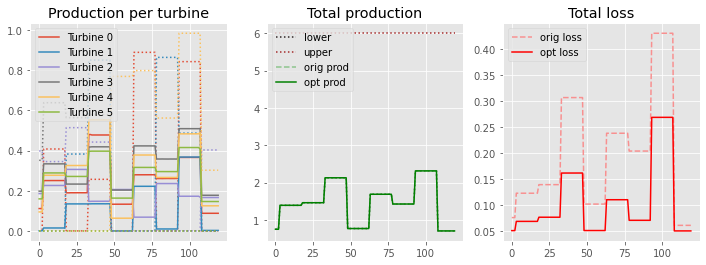

In [49]:
# Historically accurate production, starting from history
rows = 120
init = initial_values[:rows,:]

obj = TimeVaryingProductionBound(rows, model2, fixed_heights, basic_callback, 
                                original_prod_per_time[:rows], [6.0] * rows)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)

Setting problem...
Solving...
Iteration 0, val=36.2262077331543. inf_pr, inf_du, mu: 0.00, 0.23, 1.00
This is Ipopt version 3.14.2, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      720
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      720
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      720
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      120
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg

  76  1.2318927e+01 0.00e+00 2.08e-01 -11.0 1.08e-05    -  1.00e+00 3.68e-01f  1
  77  1.2318909e+01 0.00e+00 2.07e-01 -11.0 1.90e-05    -  1.00e+00 3.97e-01f  1
  78  1.2318900e+01 0.00e+00 2.40e-01 -11.0 1.11e-05    -  1.00e+00 6.18e-01f  1
  79  1.2318892e+01 0.00e+00 2.31e-01 -11.0 1.13e-05    -  1.00e+00 5.91e-01f  1
Iteration 80, val=12.318880081176758. inf_pr, inf_du, mu: 0.00, 0.19, 0.00
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.2318880e+01 0.00e+00 1.91e-01 -11.0 6.90e-06    -  1.00e+00 4.04e-01f  1
  81  1.2318880e+01 0.00e+00 2.48e-01  -9.0 1.30e-05    -  9.67e-01 5.00e-01f  2
In iteration 81, 1 Slack too small, adjusting variable bound
  82  1.2318871e+01 0.00e+00 2.15e-01  -9.1 3.42e-06    -  1.00e+00 5.75e-01f  1
  83  1.2318901e+01 0.00e+00 2.49e-01  -7.1 9.96e-06    -  7.43e-01 1.00e+00f  1
  84  1.2318891e+01 0.00e+00 2.37e-01  -7.3 4.56e-06    -  1.00e+00 2.44e-01f  1
  85  1.2318871e+01 0.00e+00 3.94e-01  -7.3 2.70e-04  

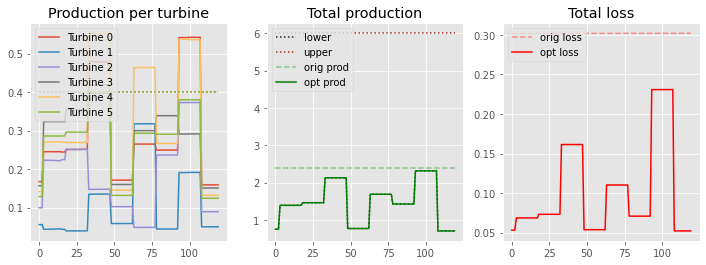

In [50]:
# Historically accurate production, starting from flat
rows = 120
init = 0.4 * np.ones((rows,6))

obj = TimeVaryingProductionBound(rows, model2, fixed_heights, basic_callback, 
                                original_prod_per_time[:rows], [6.0] * rows)
found = optimize_model(obj, init)

fig, ax = plt.subplots(1,3, figsize=(12,4))
plot_results(ax, init, found, obj)